In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [30]:
data=pd.read_csv('/content/drive/MyDrive/financial_transactions.csv')

In [31]:
data.head()

,transaction_id,date,customer_id,amount,type,description
0,1,26-10-2020,926,6478.39,deposit,Expect series shake art again our.
1,2,08-01-2020,466,1255.95,deposit,Each left similar likely coach take.
2,3,02-09-2019,110,7969.68,withdrawal,Direction wife job pull determine leader move ...
3,4,02-12-2020,142,2927.41,deposit,Agree reveal buy black already.
4,5,02-12-2020,944,4661.88,withdrawal,Child relationship show college whom speech.


In [32]:
data.describe()

,transaction_id,customer_id,amount
count,100000.000000,100000.000000,100000.000000
mean,50000.500000,499.594710,5009.012768
std,28867.657797,288.973503,2888.443654
min,1.000000,1.000000,1.290000
25%,25000.750000,249.000000,2514.572500
50%,50000.500000,499.000000,5006.135000
75%,75000.250000,750.000000,7513.840000
max,100000.000000,1000.000000,10000.000000


In [33]:
data.isnull().sum()

,0
transaction_id,0
date,0
customer_id,0
amount,0
type,0
description,0


In [34]:
data.nunique()

,0
transaction_id,100000
date,1827
customer_id,1000
amount,95195
type,3
description,100000


In [35]:
data['type'].unique()

array(['deposit', 'withdrawal', 'transfer'], dtype=object)

In [38]:
data['date'].min(), data['date'].max()

('01-01-2019', '31-12-2022')

In [39]:
# Grouping data by customer_id
customer_data = data.groupby('customer_id').agg({
    'amount': ['sum', 'mean', 'count']  # Total spend, average transaction, transaction count
})
customer_data.columns = ['total_amount', 'average_amount', 'transaction_count']
customer_data.reset_index(inplace=True)

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['total_amount', 'average_amount', 'transaction_count']])


In [40]:
customer_data.head()

,customer_id,total_amount,average_amount,transaction_count
0,1,481760.83,4966.606495,97
1,2,493403.13,4699.077429,105
2,3,547765.88,5071.906296,108
3,4,505827.29,5558.541648,91
4,5,527998.55,4934.565888,107


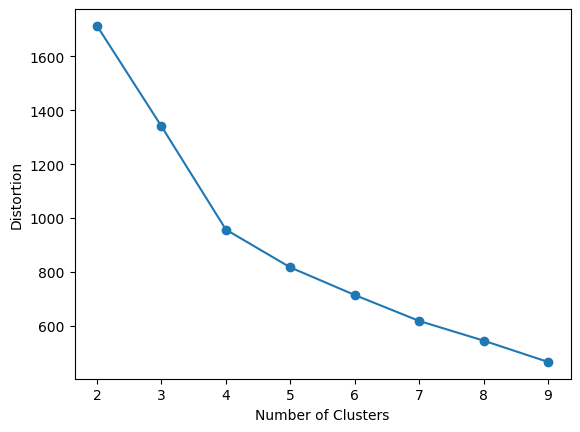

In [41]:
# Elbow Method
distortions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Curve
import matplotlib.pyplot as plt
plt.plot(range(2, 10), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

# Final Model
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_data)

In [42]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(scaled_data, customer_data['cluster'])
print(f'Davies-Bouldin Index: {db_score}')


Davies-Bouldin Index: 1.1453991566444535


In [43]:
# Silhouette Score
silhouette = silhouette_score(scaled_data, customer_data['cluster'])
print(f'Silhouette Score: {silhouette}')


Silhouette Score: 0.29915210705522804


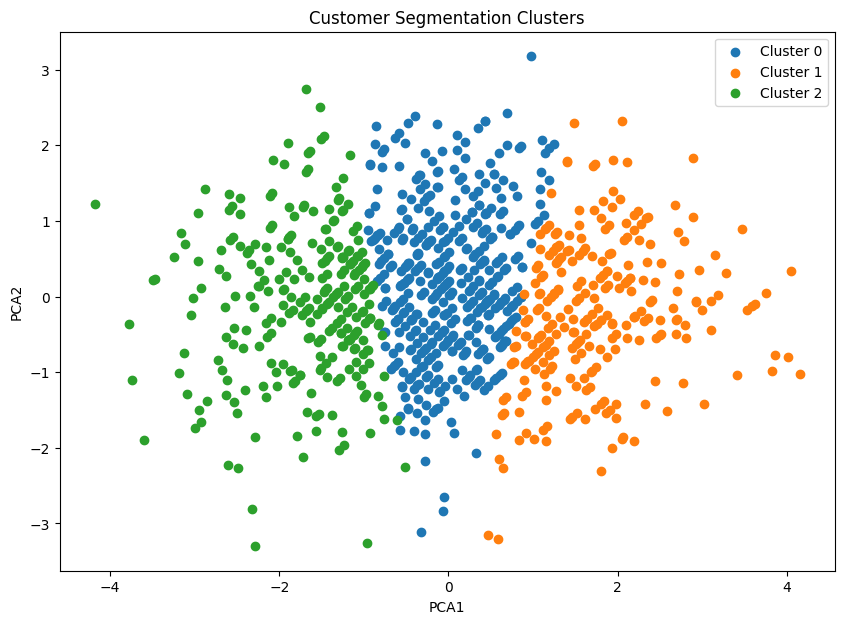

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_data['pca1'] = pca_data[:, 0]
customer_data['pca2'] = pca_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 7))
for cluster in customer_data['cluster'].unique():
    cluster_data = customer_data[customer_data['cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.title('Customer Segmentation Clusters')
plt.show()


In [45]:
customer_data.groupby('cluster').mean()


,customer_id,total_amount,average_amount,transaction_count,pca1,pca2
cluster,,,,,,
0,486.893246,500679.320654,5060.102561,99.156863,0.009943,0.191275
1,509.872659,572262.146704,5148.323334,111.292135,1.748074,-0.227130
2,514.160584,431735.311971,4786.278353,90.408759,-1.720072,-0.099093


In [46]:
# Extract relevant features for clustering
features = customer_data[["average_amount", "transaction_count"]]

In [47]:
from sklearn.cluster import KMeans

# Apply K-Means Clustering (choose n_clusters based on business requirements)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['new_cluster'] = kmeans.fit_predict(features)

# Check the updated data
print(customer_data[['average_amount', 'transaction_count', 'new_cluster']].head())


   average_amount  transaction_count  new_cluster
0     4966.606495                 97            0
1     4699.077429                105            1
2     5071.906296                108            0
3     5558.541648                 91            2
4     4934.565888                107            0


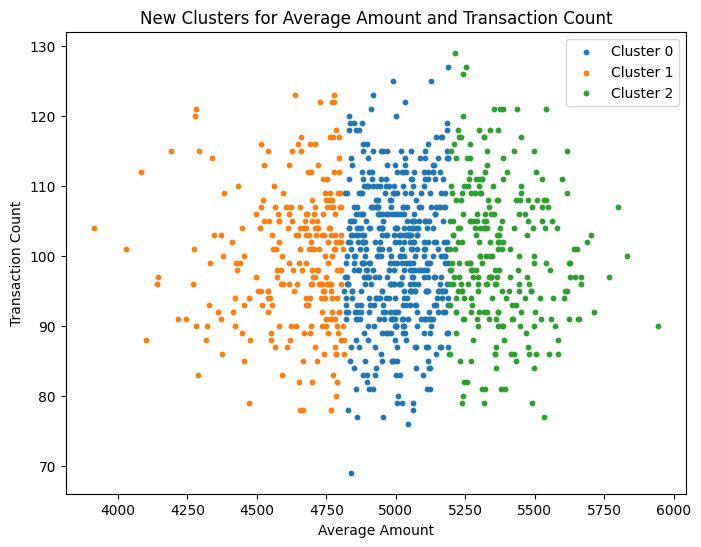

In [48]:
import matplotlib.pyplot as plt

# Plot new clusters
plt.figure(figsize=(8, 6))
for cluster in customer_data['new_cluster'].unique():
    cluster_data = customer_data[customer_data['new_cluster'] == cluster]
    plt.scatter(
        cluster_data["average_amount"],
        cluster_data["transaction_count"],
        label=f"Cluster {cluster}",
        s=10
    )

plt.xlabel("Average Amount")
plt.ylabel("Transaction Count")
plt.title("New Clusters for Average Amount and Transaction Count")
plt.legend()
plt.show()
